In [1]:
!pip install transformers==3.3.1
!git clone https://github.com/adeepH/OLD-Shared-Task.git

fatal: destination path 'OLD-Shared-Task' already exists and is not an empty directory.


In [2]:
import pandas as pd
train = pd.read_csv('/content/mal_train.csv',delimiter='\t',
                 header=None,names=['text','label','nan'])
train = train.drop(columns=['nan'])
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,
'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)
val = pd.read_csv('/content/mal_dev.csv',delimiter='\t',
                 header=None,names=['text','label','nan'])
val = val.drop(columns=['nan'])
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,
'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)

#test = pd.read_csv('/content/drive/MyDrive/sdpra2021/test.csv',delimiter=',',
#                 header=None,names=['text'])

In [3]:
train.label.value_counts()

0    14153
4     1287
3      239
1      191
2      140
Name: label, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
from transformers import set_seed
set_seed(52)
train,eval = train_test_split(train,test_size=0.25,shuffle=True)
print('Training set size:',train.shape)
print('Testing set size:',val.shape)
print('validation set size:',eval.shape)

Training set size: (12007, 2)
Testing set size: (1999, 2)
validation set size: (4003, 2)


In [5]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [6]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.label.values),
                                                  train.label.values)
class_weights

array([ 0.22695397, 15.79868421, 22.23518519, 12.70582011,  2.45793245])

In [7]:
def create_data_loader(df,tokenizer,max_len,batch_size,shuffle):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = shuffle,
                    num_workers=4)

In [8]:
from transformers import  AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)


In [9]:
BATCH_SIZE = 16
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)

In [10]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [11]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes,pre_trained):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained(pre_trained,return_dict=False)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return nn.functional.softmax(self.out(output))

In [12]:
import torch.nn as nn
from transformers import BertModel,BertTokenizer
class MixedBertModel(nn.Module):
    def __init__(self,pre_trained='bert-base-uncased'):
        super().__init__()
        
        self.bert = BertModel.from_pretrained(pre_trained)
        self.hidden_size = self.bert.config.hidden_size
        self.LSTM = nn.LSTM(self.hidden_size,self.hidden_size,bidirectional=True)
        self.clf = nn.Linear(self.hidden_size*2,1)
        
    def forward(self,inputs):
        
        encoded_layers, pooled_output = self.bert(input_ids=inputs[0],attention_mask=inputs[1])
        encoded_layers = encoded_layers.permute(1, 0, 2)
        enc_hiddens, (last_hidden, last_cell) = self.LSTM(pack_padded_sequence(encoded_layers, inputs[2]))
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
        output_hidden = F.dropout(output_hidden,0.2)
        output = self.clf(output_hidden)
        
        return F.softmax(output,dim=1)

In [13]:
model = RFClassifier(5,'bert-base-multilingual-cased')
#model = MixedBertModel()
model = model.to(device)

In [14]:

EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-uncased.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 01 | Epoch Time: 5m 18s
Train Loss 1.0290509566327386 accuracy 0.8808195219455317
Val Loss 1.0148926730155945 accuracy 0.889944972486243

Epoch: 02 | Epoch Time: 5m 18s
Train Loss 1.023606686792107 accuracy 0.8812359456983426
Val Loss 1.014848340511322 accuracy 0.889944972486243



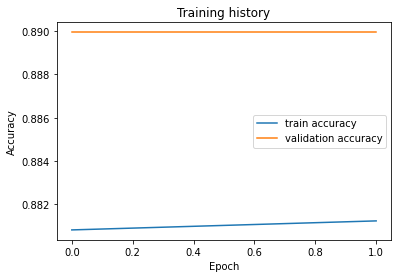

In [19]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [20]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.889944972486243

In [21]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [22]:
test_data_loader = create_data_loader(eval,tokenizer,MAX_LEN,BATCH_SIZE,True) 

In [23]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [24]:
class_name = ['Not_offensive' ,'Offensive_Untargetede' ,'Offensive_Targeted_Insult_Group' ,
'Offensive_Targeted_Insult_Individual' ,'not-malayalam' ]

In [25]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                                      precision    recall  f1-score   support

                       Not_offensive       0.89      1.00      0.94      3572
               Offensive_Untargetede       0.00      0.00      0.00        39
     Offensive_Targeted_Insult_Group       0.00      0.00      0.00        32
Offensive_Targeted_Insult_Individual       0.00      0.00      0.00        50
                       not-malayalam       0.00      0.00      0.00       310

                            accuracy                           0.89      4003
                           macro avg       0.18      0.20      0.19      4003
                        weighted avg       0.80      0.89      0.84      4003



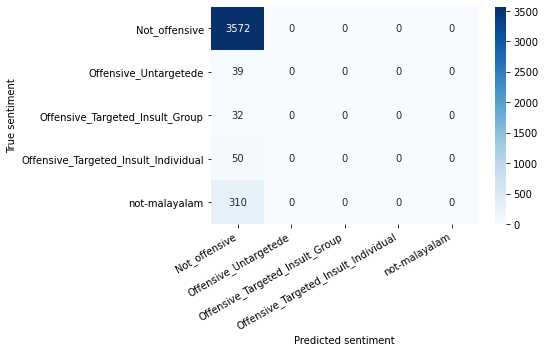

In [26]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)